In [6]:
import os
import sys
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import h5py
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append(os.path.abspath("TRIDENT"))

from TRIDENT.code import config
from trident.slide_encoder_models import ABMILSlideEncoder

In [10]:
print(config.T_mult)

2


In [12]:
# Set deterministic behavior
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### ABMIL Model

In [14]:
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_feature_dim=1536, n_heads=1, head_dim=512, dropout=0., gated=True, hidden_dim=256):
        super().__init__()
        self.feature_encoder = ABMILSlideEncoder(
            input_feature_dim=input_feature_dim, 
            n_heads=n_heads, 
            head_dim=head_dim, 
            dropout=dropout, 
            gated=gated
        )
        self.classifier = nn.Sequential(
            nn.Linear(input_feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
            #Has only 1 neuron head for classification before apply sigmoid or etc to predict the probability
        )

    def forward(self, x, return_raw_attention=False):
        if return_raw_attention:
            features, attn = self.feature_encoder(x, return_raw_attention=True)
        else:
            features = self.feature_encoder(x)
        logits = self.classifier(features).squeeze(1)
        
        if return_raw_attention:
            return logits, attn
        
        return logits


In [15]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BinaryClassificationModel().to(device)

In [7]:
print(model)

BinaryClassificationModel(
  (feature_encoder): ABMILSlideEncoder(
    (model): ModuleDict(
      (pre_attention_layers): Sequential(
        (0): Linear(in_features=1536, out_features=1536, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
      )
      (image_pooler): ABMIL(
        (attention_heads): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=1536, out_features=512, bias=True)
            (1): Tanh()
            (2): Dropout(p=0.0, inplace=False)
          )
        )
        (gating_layers): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=1536, out_features=512, bias=True)
            (1): Sigmoid()
            (2): Dropout(p=0.0, inplace=False)
          )
        )
        (branching_layers): ModuleList(
          (0): Linear(in_features=512, out_features=1, bias=True)
        )
      )
      (post_attention_layers): Sequential(
        (0): Linear(in_features=1536, out_features=1

### Dataset

In [16]:
class DRESSDataset(Dataset):
    def __init__(self, feats_path, df, split, num_features=512, seed = 42):
        self.df = df[df["split"] == split] if 'split' in df.columns else df
        self.feats_path = feats_path
        self.num_features = num_features
        self.seed = seed

        self.label_encoder = LabelEncoder()
        self.df = self.df.copy()
        self.df['label_encoder'] = self.label_encoder.fit_transform(self.df['label'])
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        slide_path = row['path']
        slide_path = slide_path.replace("\\", "/")
        basename = os.path.basename(slide_path)

        feature_file = os.path.join(self.feats_path, f"{basename}.h5")
        if not os.path.exists(feature_file):
            raise FileNotFoundError(f"Feature file {feature_file} not found")

        with h5py.File(feature_file, 'r') as f:
            features = torch.from_numpy(f["features"][:])

        if self.num_features:
            num_available = features.shape[0]
            generator = torch.Generator().manual_seed(self.seed)
            if num_available >= self.num_features:
                indices = torch.randperm(num_available, generator=generator)[:self.num_features]
            else:
                indices = torch.randint(num_available, (self.num_features,), generator=generator)
            features = features[indices]

        label = torch.tensor(row['label_encoder'], dtype=torch.long)
        return features, label

In [21]:
feats_path = 'Result/feature_extraction_UNIv2/20x_256px_0px_overlap/features_uni_v2'
csv_path = "dataset_csv/dataset_split.csv"
df = pd.read_csv(csv_path)
batch_size = 4
num_train_samples = 2  # Number of training samples to use

# Create full dataset
train_dataset = DRESSDataset(feats_path, df, "train")
test_dataset = DRESSDataset(feats_path, df, "test")
val_dataset = DRESSDataset(feats_path, df, "val")

# Create a subset of the training dataset
train_subset_indices = list(range(min(num_train_samples, len(train_dataset))))
train_subset = Subset(train_dataset, train_subset_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))


In [18]:
print(len(os.listdir(feats_path)))

265


# Training

In [33]:
def training(train_loader,val_loader, fold, device, config):
    model = BinaryClassificationModel()
    model.to(device)

    criterion = config.LOSS_FUNCTION
    optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=config.T_0, T_mult=config.T_mult, eta_min=config.eta_min)

    best_val_loss = float("inf")
    best_model_path = config.MODEL_NAME_TEMPLATE.format(config.OPTIM, config.LEARNING_RATE, f"fold{fold}")

    patience = config.PATIENCE
    patience_counter = 0
    train_losses, val_losses = [],[]

    for epoch in range(config.NUM_EPOCHS):
        model.train()
        total_train_loss = 0.
        with tqdm(train_loader, desc=f"Fold {fold} Epoch {epoch+1}/{config.NUM_EPOCHS} (Train)", unit="batch") as t:
            for features, labels in t:
                features, labels = {"features": features.to(device)}, labels.to(device).float()
                optimizer.zero_grad()
                outputs = model(features)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                t.set_postfix(loss=total_train_loss / (t.n +1) )

        scheduler.step()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        #Validation
        model.eval()
        total_val_loss = 0.
        with torch.no_grad():
            with tqdm(val_loader, desc=f"Fold {fold} Epoch {epoch+1}/{config.NUM_EPOCHS} (Val)", unit="batch") as t:
                for features, labels in t:
                    features, labels = {'features': features.to(device)}, labels.to(device).float()
                    outputs = model(features)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()
                    t.set_postfix(val_loss=total_val_loss / (t.n + 1))
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Model saved at {best_model_path} (Best Val Loss: {best_val_loss: .4f})")
        else:
            patience_counter += 1
            print(f"No imporvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    print(f"Fold {fold} training complete, Best Val Loss: {best_val_loss: .4f}")


In [34]:
def run_kfold(train_loader,val_loader, meatadata_path,config, num_folds=5,batch_size=32,seed=42):
    df = pd.read_csv(meatadata_path)
    df['label_encoded'] = LabelEncoder().fit_transform(df['label'])

    cross_val = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

    for fold, (train_idx,val_idx) in enumerate(cross_val.split(df, df['label_encoded'])):
        print(f"Fold {fold+1}/{num_folds}")

        training(train_loader, val_loader, fold=fold, device=device, config=config)

In [35]:
run_kfold(train_loader=train_loader,val_loader=val_loader, meatadata_path=csv_path, config=config, num_folds=5, batch_size=4)

Fold 1/5


Fold 0 Epoch 1/2 (Val): 100%|██████████| 39/39 [00:04<00:00,  8.23batch/s, val_loss=0.722]


Model saved at Model/model_AdamW_lr0.0004_fold0.pth (Best Val Loss:  0.7038)


Fold 0 Epoch 2/2 (Val): 100%|██████████| 39/39 [00:03<00:00, 10.58batch/s, val_loss=0.71] 


Model saved at Model/model_AdamW_lr0.0004_fold0.pth (Best Val Loss:  0.6914)
Fold 0 training complete, Best Val Loss:  0.6914
Fold 2/5


Fold 1 Epoch 1/2 (Val): 100%|██████████| 39/39 [00:03<00:00, 10.30batch/s, val_loss=0.732]


Model saved at Model/model_AdamW_lr0.0004_fold1.pth (Best Val Loss:  0.7135)


Fold 1 Epoch 2/2 (Val):  41%|████      | 16/39 [00:01<00:02,  9.57batch/s, val_loss=0.674]


KeyboardInterrupt: 

# Evaluation

In [ ]:
def evaluate_model(model, model_path, test_loader, device=None):
    """
    Evaluates a PyTorch model on a test dataset and computes classification metrics.
    
    Args:
        model (torch.nn.Module): The PyTorch model architecture (without weights loaded).
        model_path (str): Path to the saved model weights (.pth file).
        test_loader (DataLoader): Dataloader for the test dataset.
        device (torch.device, optional): Device to run evaluation (CPU/GPU). Defaults to auto-detect.

    Returns:
        dict: Dictionary containing computed metrics (Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC).
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()  # Set to evaluation mode

    y_true, y_pred, y_probs = [], [], []

    # Disable gradient tracking for evaluation
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = {'features': images.to(device)}, labels.to(device)

            # Forward pass
            outputs = model(images)

            # Apply sigmoid activation for binary classification
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()

            # Store results
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # Compute Metrics
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall (Sensitivity)": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_probs),
        "PR AUC": average_precision_score(y_true, y_probs),
    }

    # Print Results
    print("\n--- Evaluation Metrics ---")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {metrics['ROC AUC']:.2f})", color="blue")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.show()

    # Plot Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(recall_vals, precision_vals, label=f"PR curve (AUC = {metrics['PR AUC']:.2f})", color="red")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

    return metrics


# Heatmaps

In [3]:
import torch

torch.cuda.empty_cache() 
torch.cuda.reset_peak_memory_stats()

In [4]:
from trident import OpenSlideWSI, visualize_heatmap
from trident.segmentation_models import segmentation_model_factory
from trident.patch_encoder_models import encoder_factory as patch_encoder_factory

In [5]:
# a. Load WSI to process
job_dir = './tutorial-3/heatmap_viz'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
slide = OpenSlideWSI(slide_path='Dataset/OSU/MDE/S10-10100  B-1.svs', lazy_init=False)

# b. Run segmentation 
segmentation_model = segmentation_model_factory("hest", device=device)
geojson_contours = slide.segment_tissue(segmentation_model=segmentation_model, job_dir=job_dir)

Using cache found in /home/siradakittipaisarnkul/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/envs/trident/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 14, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
coords_path = slide.extract_tissue_coords(
    target_mag=20,
    patch_size=256,
    save_coords=job_dir,
    overlap=0, 
)

In [7]:
# d. Run patch feature extraction
patch_encoder = patch_encoder_factory("uni_v2").eval().to(device)
patch_features_path = slide.extract_patch_features(
    patch_encoder=patch_encoder,
    coords_path=coords_path,
    save_features=os.path.join(job_dir, f"features_UniV2"),
    device=device
)

#  e. Run inference 
with h5py.File(patch_features_path, 'r') as f:
    coords = f['coords'][:]
    patch_features = f['features'][:]
    coords_attrs = dict(f['coords'].attrs)

batch = {'features': torch.from_numpy(patch_features).float().to(device).unsqueeze(0)}

model_weights_path = "Model/model_AdamW_lr0.0004_best.pth"

model = BinaryClassificationModel().to(device)
model.load_state_dict(torch.load(model_weights_path, map_location=device))
model.eval()

with torch.no_grad(): 
    logits, attention = model(batch, return_raw_attention=True)

# f. generate heatmap
heatmap = visualize_heatmap(
    wsi=slide,
    scores=attention.cpu().numpy().squeeze(),  
    coords=coords,
    vis_level=1,
    patch_size_level0=coords_attrs['patch_size_level0'],
    normalize=True,
)
heatmap.save(os.path.join(job_dir, f'{slide.name}_heatmap.jpg'))


/opt/conda/envs/trident/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 72 worker processes in total. Our suggested max number of worker in current system is 14, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [16]:
print(len(test_loader))

57


## Warm restart

tensor([-1.1838], device='cuda:0')
tensor([-1.1740], device='cuda:0')
tensor([-1.1885], device='cuda:0')
tensor([-1.1042], device='cuda:0')
tensor([-0.9713], device='cuda:0')
tensor([-0.8530], device='cuda:0')
tensor([-0.6892], device='cuda:0')
tensor([-1.2304], device='cuda:0')
tensor([-1.8314], device='cuda:0')
tensor([-1.9571], device='cuda:0')
tensor([-1.8048], device='cuda:0')
tensor([-1.3347], device='cuda:0')
tensor([-1.3905], device='cuda:0')
tensor([-0.4320], device='cuda:0')
tensor([-0.3125], device='cuda:0')
tensor([-0.5043], device='cuda:0')
tensor([-0.7118], device='cuda:0')
tensor([-0.6083], device='cuda:0')
tensor([-0.3217], device='cuda:0')
tensor([-0.2759], device='cuda:0')
tensor([-0.5802], device='cuda:0')
tensor([-0.2891], device='cuda:0')
tensor([0.0252], device='cuda:0')
tensor([-0.3962], device='cuda:0')
tensor([-0.6610], device='cuda:0')
tensor([-0.4739], device='cuda:0')
tensor([-0.3622], device='cuda:0')
tensor([0.0432], device='cuda:0')
tensor([-0.1335], devi

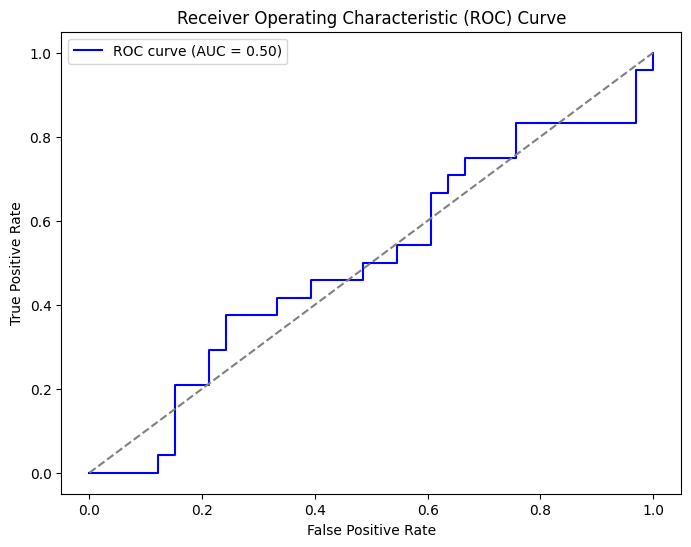

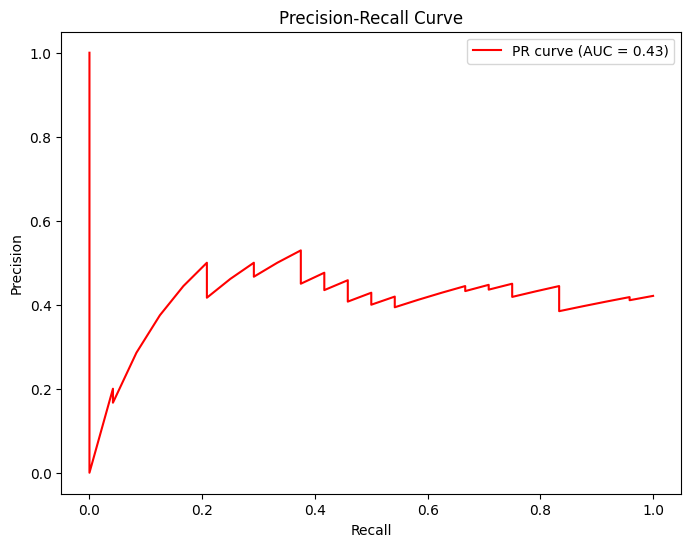

In [ ]:
model_path = "Model/model_AdamW_cosinwrmrestrt.pth"  # Update with your actual path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set to evaluation mode

# Load your test dataset
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

y_true = []
y_pred = []
y_probs = []  # Probabilities for ROC/PR-AUC

# Disable gradient tracking for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = {'features': images.to(device)}, labels.to(device)

        # Forward pass
        outputs = model(images)
        
        # If the model outputs logits, apply softmax
        probs = torch.sigmoid(outputs)   # Probability of class 1
        preds = (probs > 0.5).int()  # Convert to binary predictions

        # Store results
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

# Compute Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)
pr_auc = average_precision_score(y_true, y_probs)

# Print Results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f"PR curve (AUC = {pr_auc:.2f})", color="red")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


## 1e-5

tensor([-0.0514], device='cuda:0')
tensor([-0.0510], device='cuda:0')
tensor([-0.0503], device='cuda:0')
tensor([-0.0549], device='cuda:0')
tensor([-0.0521], device='cuda:0')
tensor([-0.0538], device='cuda:0')
tensor([-0.0538], device='cuda:0')
tensor([-0.0609], device='cuda:0')
tensor([-0.0616], device='cuda:0')
tensor([-0.0486], device='cuda:0')
tensor([-0.0498], device='cuda:0')
tensor([-0.0514], device='cuda:0')
tensor([-0.0528], device='cuda:0')
tensor([-0.0502], device='cuda:0')
tensor([-0.0492], device='cuda:0')
tensor([-0.0493], device='cuda:0')
tensor([-0.0573], device='cuda:0')
tensor([-0.0581], device='cuda:0')
tensor([-0.0495], device='cuda:0')
tensor([-0.0509], device='cuda:0')
tensor([-0.0568], device='cuda:0')
tensor([-0.0603], device='cuda:0')
tensor([-0.0431], device='cuda:0')
tensor([-0.0598], device='cuda:0')
tensor([-0.0577], device='cuda:0')
tensor([-0.0529], device='cuda:0')
tensor([-0.0532], device='cuda:0')
tensor([-0.0452], device='cuda:0')
tensor([-0.0467], de

c:\Users\ppffx\anaconda3\envs\trident\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


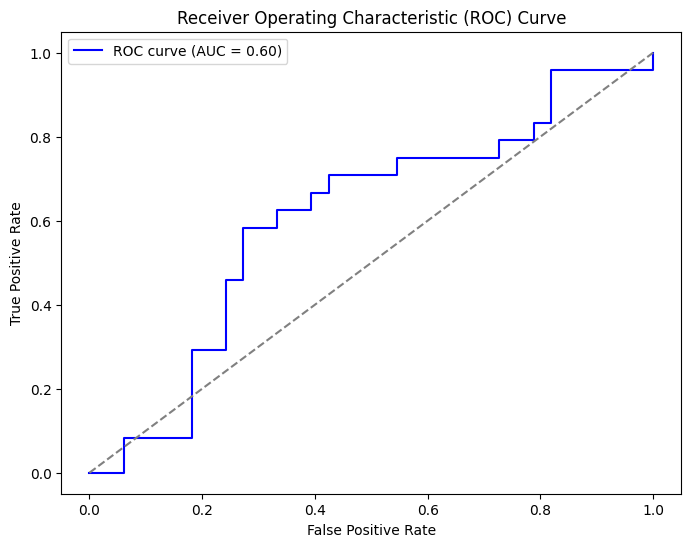

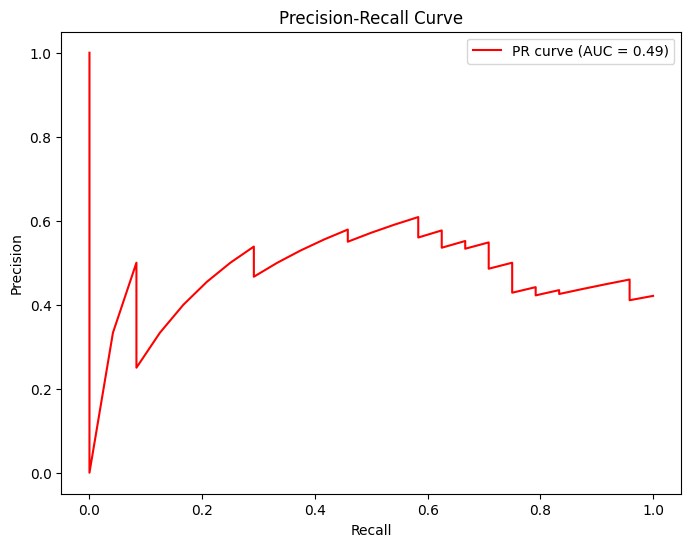

In [43]:
model_path = "Model/model_AdamW_lr1e-05_best.pth"  # Update with your actual path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set to evaluation mode

# Load your test dataset
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

y_true = []
y_pred = []
y_probs = []  # Probabilities for ROC/PR-AUC

# Disable gradient tracking for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = {'features': images.to(device)}, labels.to(device)

        # Forward pass
        outputs = model(images)
        
        # If the model outputs logits, apply softmax
        probs = torch.sigmoid(outputs)   # Probability of class 1
        preds = (probs > 0.5).int()  # Convert to binary predictions

        # Store results
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

# Compute Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)
pr_auc = average_precision_score(y_true, y_probs)

# Print Results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f"PR curve (AUC = {pr_auc:.2f})", color="red")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


Accuracy: 0.5789
Precision: 0.0000
Recall (Sensitivity): 0.0000
F1 Score: 0.0000
ROC AUC: 0.6048
PR AUC: 0.4923


c:\Users\ppffx\anaconda3\envs\trident\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


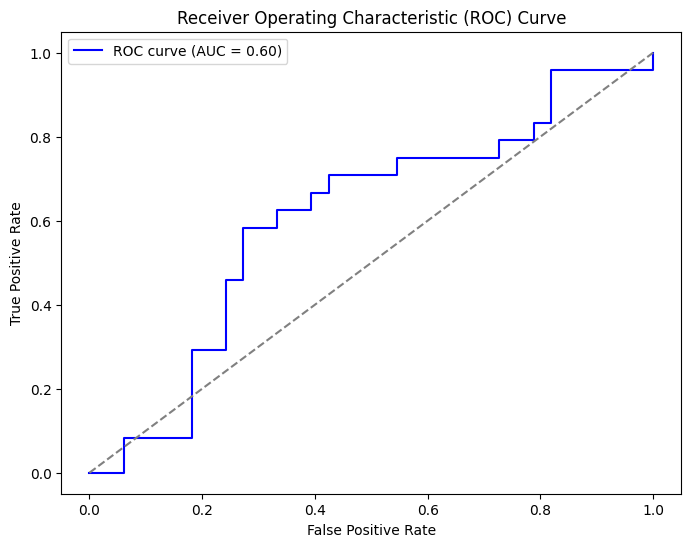

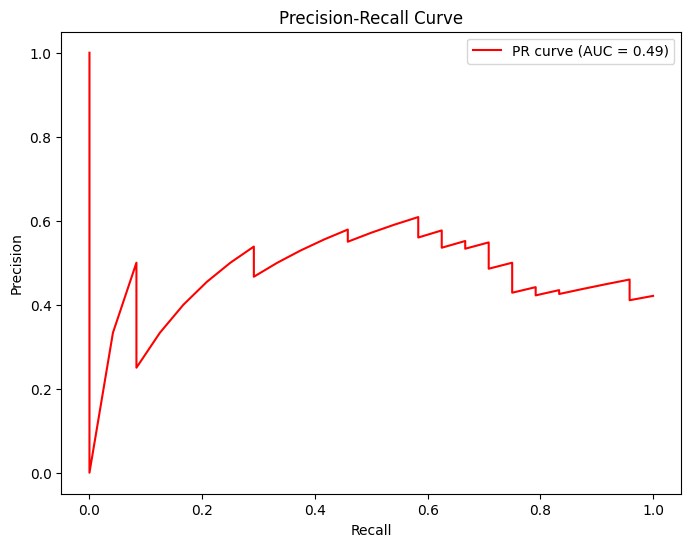

In [44]:
model_path = "Model/model_AdamW_lr1e-05_best.pth"  # Update with your actual path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set to evaluation mode

# Load your test dataset
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

y_true = []
y_pred = []
y_probs = []  # Probabilities for ROC/PR-AUC

# Disable gradient tracking for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = {'features': images.to(device)}, labels.to(device)

        # Forward pass
        outputs = model(images)
        
        # If the model outputs logits, apply softmax
        probs = torch.sigmoid(outputs)   # Probability of class 1
        preds = (probs > 0.5).int()  # Convert to binary predictions

        # Store results
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

# Compute Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)
pr_auc = average_precision_score(y_true, y_probs)

# Print Results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f"PR curve (AUC = {pr_auc:.2f})", color="red")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()
